# 🌀 Diffusion Models

Diffusion models can be considered hierarchicals VAE without a learned encoder

## 🎯 Motivation: Generating High-Quality Images

Diffusion models are a powerful class of **generative models** that can produce stunningly realistic images. They do this by learning how to **gradually denoise** random noise into data — in contrast to VAEs or GANs which directly output samples in one step.

---

## 🌫️ Forward Process: Diffusion

We define a **forward (noising) process** $q(x_{1:T} \mid x_0)$ that gradually adds Gaussian noise to a data sample $x_0$ over $T$ discrete time steps.

This process forms a **Markov chain** — each noisy sample $x_t$ depends **only on** the previous step $x_{t-1}$:

$$
q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} \, x_{t-1}, \beta_t \mathbf{I})
$$

Where:

- $x_0$ is the original data sample
- $\beta_1, \dots, \beta_T$ is a fixed noise schedule
- As $t \to T$, $x_t$ becomes increasingly noisy and approaches pure Gaussian noise

> **About $\beta_t$**: Each $\beta_t$ controls how much **variance** is added at step $t$. Equivalently, we can define $\alpha_t = 1 - \beta_t$. Then, for each step:
> $$
> x_t = \sqrt{\alpha_t}\,x_{t-1} \;+\; \sqrt{1 - \alpha_t}\,\epsilon_t,
> $$
> where $\epsilon_t \sim \mathcal{N}(0,\mathbf{I})$. This $\beta$-based schedule allows direct control of the **amount of noise** injected each step.

The full joint distribution over the diffusion trajectory is:

$$
q(x_{1:T} \mid x_0) = \prod_{t=1}^T q(x_t \mid x_{t-1})
$$

Because this is a **Markov process**, we don’t need to condition on the entire history — just the immediate predecessor.

---

## 🏎 Beta Schedules: Linear vs. Cosine

### Linear Beta Scheduling

- **Linear**: We simply pick $\beta_t$ to increase linearly from $\beta_{\text{start}}$ to $\beta_{\text{end}}$.  
- For example, $$\beta_t = \beta_{\text{start}} + t \cdot \frac{(\beta_{\text{end}} - \beta_{\text{start}})}{T-1}.$$
- **Pros**: Simple and easy to tune.
- **Cons**: Often adds too little noise in early steps and too much in later steps, sometimes causing less stable training or splotchy samples.

### Cosine Beta Scheduling

- **Cosine**: Proposed in *Improved DDPM* (Nichol & Dhariwal, 2021).
- Instead of defining $\beta_t$ directly, we define the cumulative product $\bar{\alpha}_t$ via a **cosine** function:
  $$
  \bar{\alpha}_t \;=\; \frac{\cos^2\!\bigl(\tfrac{(t/T + s)}{1 + s}\,\tfrac{\pi}{2}\bigr)}{\cos^2\!\bigl(\tfrac{s}{1 + s}\,\tfrac{\pi}{2}\bigr)},
  $$
  then recover $\beta_t$ from $\beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}.$
- **Pros**: Smoother schedule; preserves more signal in early steps; often yields better sample quality.
- **Cons**: Slightly more complex to implement, though the code is still straightforward.

---

## 🔁 Reverse Process: Generative Modeling

To generate data, we define a **reverse-time Markov chain**:

$$
p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \mid x_t)
$$

Here:

- $p(x_T) = \mathcal{N}(0, \mathbf{I})$ is the starting point — pure Gaussian noise
- $p_\theta(x_{t-1} \mid x_t)$ is a learnable Gaussian distribution, parameterized by a neural network

Just like the forward process, this reverse chain is **Markovian**. Each step only depends on the current state $x_t$, not the entire history

This Markov structure simplifies the generative modeling process: we only need to learn how to take one step back in time, many times in a row.

Ideally, the learned reverse process $p_\theta(x_{t-1} \mid x_t)$ should match the true reverse conditionals $q(x_{t-1} \mid x_t, x_0)$ derived from the forward process.

---

## 📉 Variational Inference: ELBO Objective

Our ultimate goal is to model the **data distribution** $p_{\text{data}}(x_0)$ using a parameterized model $p_\theta(x_0)$. Ideally, we want to maximize:

$$
\log p_\theta(x_0)
$$

However, in a **latent variable model** like diffusion (or VAEs), $x_0$ is generated via **intermediate latent variables** — in this case, the noised versions $x_1, x_2, ..., x_T$.

So the marginal likelihood becomes:

$$
\log p_\theta(x_0) = \log \int p_\theta(x_0, x_1, ..., x_T) \, dx_{1:T}
= \log \int p_\theta(x_{0:T}) \, dx_{1:T}
$$

This integral is **intractable** because:

- $p_\theta(x_{t-1} \mid x_t)$ is parameterized by a neural network
- The latent space is high-dimensional (a trajectory over $T$ steps)

---

### 💡 Variational Trick: Importance Sampling

To deal with this, we apply **importance sampling**: introduce a known, tractable distribution $q(x_{1:T} \mid x_0)$ (the **forward diffusion process**) and rewrite the integral:

$$
\log p_\theta(x_0)
= \log \int \frac{q(x_{1:T} \mid x_0)}{q(x_{1:T} \mid x_0)} \, p_\theta(x_{0:T}) \, dx_{1:T}
= \log \mathbb{E}_{q(x_{1:T} \mid x_0)} \left[ \frac{p_\theta(x_{0:T})}{q(x_{1:T} \mid x_0)} \right]
$$

This is **exact** — we haven't approximated anything yet.

---

### ✅ Now Comes the Inequality: Jensen’s Inequality

The log of an expectation is **not equal to** the expectation of a log. In fact, by **Jensen’s inequality**, we have:

$$
\log \mathbb{E}_{q} \left[ f(x) \right] \geq \mathbb{E}_{q} \left[ \log f(x) \right]
$$

So applying this to our case:

$$
\log p_\theta(x_0)
= \log \mathbb{E}_{q(x_{1:T} \mid x_0)} \left[ \frac{p_\theta(x_{0:T})}{q(x_{1:T} \mid x_0)} \right]
\geq \mathbb{E}_{q(x_{1:T} \mid x_0)} \left[ \log \frac{p_\theta(x_{0:T})}{q(x_{1:T} \mid x_0)} \right]
$$

This **lower bound** is called the **Evidence Lower Bound (ELBO)**:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_{1:T} \mid x_0)} \left[
\log p_\theta(x_{0:T}) - \log q(x_{1:T} \mid x_0)
\right]
$$

---

### 📌 Intuition

- We're approximating the true (intractable) marginal likelihood with a **lower bound** that we can **actually compute and optimize**.
- The closer $q(x_{1:T} \mid x_0)$ is to the true posterior $p_\theta(x_{1:T} \mid x_0)$, the **tighter** the bound.
- In VAEs, $q$ is learned. In diffusion, it’s **fixed** and designed — but still works because we structure it well (Gaussian forward steps).

---

## 🔁 Modeling the Joint Distributions

Let’s expand both terms:

### 🔹 Reverse (Generative) Process:

We define the joint generative distribution as:

$$
p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \mid x_t)
$$

Where:

- $p(x_T)$ is the standard Gaussian prior
- $p_\theta(x_{t-1} \mid x_t)$ is modeled as a Gaussian parameterized by a neural net

### 🔹 Forward (Variational) Process:

The forward process (used for inference) is fixed and Markovian:

$$
q(x_{1:T} \mid x_0) = \prod_{t=1}^T q(x_t \mid x_{t-1})
$$

---

## 🧮 ELBO Breakdown

Plugging the expressions in:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_{1:T} \mid x_0)} \left[
\log p(x_T) + \sum_{t=1}^T \log p_\theta(x_{t-1} \mid x_t)
- \sum_{t=1}^T \log q(x_t \mid x_{t-1})
\right]
$$

Group terms by time step:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_{1:T} \mid x_0)} \left[
\log p(x_T) - \log q(x_1 \mid x_0)
+ \log p_\theta(x_0 \mid x_1)
+ \sum_{t=2}^T \left(
\log p_\theta(x_{t-1} \mid x_t) - \log q(x_t \mid x_{t-1})
\right)
\right]
$$

Rewriting in terms of KLs (using the closed-form for KL between Gaussians):

---

## 🔍 Interpretation of the ELBO Terms

### 🔹 1. Prior Matching at $t = T$

Encourages the terminal distribution $x_T$ to match the prior:

$$
D_{\text{KL}}(q(x_T \mid x_0) \, \| \, p(x_T))
$$

---

### 🔹 2. Reverse KL Terms for $t = 2, \dots, T$

Match the learned reverse distribution to the true posterior:

$$
\mathbb{E}_{q(x_{t}, x_{t-1} \mid x_0)} \left[
D_{\text{KL}} \left( q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t) \right)
\right]
$$

These KLs can be computed in closed form because all distributions are Gaussian.

---

### 🔹 3. Reconstruction Term at $t=1$

At the final step, the model attempts to reconstruct $x_0$ from the slightly noised $x_1$:

$$
- \mathbb{E}_{q(x_1 \mid x_0)} \left[ \log p_\theta(x_0 \mid x_1) \right]
$$

This is analogous to the VAE reconstruction loss.

---

## ✅ Final Variational Loss (Full DDPM Objective)

Bringing it all together:

$$
\mathcal{L}_{\text{VLB}} =
\underbrace{D_{\text{KL}}(q(x_T \mid x_0) \,\|\, p(x_T))}_{\text{Prior term}}
+ \sum_{t=2}^T
\underbrace{D_{\text{KL}}(q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t))}_{\text{Reverse KLs}}
- \underbrace{\mathbb{E}_{q(x_1 \mid x_0)} \left[ \log p_\theta(x_0 \mid x_1) \right]}_{\text{Reconstruction}}
$$

This is the **original training objective** introduced in _DDPM (Ho et al., 2020)_ — and is a true variational lower bound on $\log p_\theta(x_0)$.

---

## ✂️ Simplifying the ELBO: From Variational Bound to Noise Prediction

In practice, diffusion models are trained using a **much simpler objective** than the full ELBO derived earlier. This section explains why that's valid and how it works.

---

### 🔁 Recall: The Full ELBO

The full ELBO from the DDPM objective is:

$$
\mathcal{L}_{\text{VLB}} =
D_{\text{KL}}(q(x_T \mid x_0) \,\|\, p(x_T))
+ \sum_{t=2}^T D_{\text{KL}}(q(x_{t-1} \mid x_t, x_0) \,\|\, p_\theta(x_{t-1} \mid x_t))
- \mathbb{E}_{q(x_1 \mid x_0)} \left[ \log p_\theta(x_0 \mid x_1) \right]
$$

The **KL terms** at each timestep measure how well the learned reverse distribution $p_\theta(x_{t-1} \mid x_t)$ matches the true reverse posterior $q(x_{t-1} \mid x_t, x_0)$.

---

### 🧠 Insight: KL Between Gaussians Has a Closed Form

All distributions involved are Gaussian, so we can compute the KL divergence analytically.

Specifically, for each $t \geq 1$, the true posterior is:

$$
q(x_{t-1} \mid x_t, x_0) = \mathcal{N}\left(x_{t-1}; \mu_q(x_t, x_0), \Sigma_q(t)\right)
$$

We approximate it with:

$$
p_\theta(x_{t-1} \mid x_t) = \mathcal{N}\left(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(t)\right)
$$

To minimize the KL divergence between these two Gaussians, we only need to match their **means** (since variances are fixed or learned separately). So:

> Training reduces to minimizing the squared error between the true posterior mean $\mu_q(x_t, x_0)$ and the predicted mean $\mu_\theta(x_t, t)$.

---

### 🧩 Expressing the True Mean $\mu_q$ in Terms of Noise $\epsilon$

From the **forward process**, we know that the noisy image at timestep $t$ can be written as a linear combination of the original image $x_0$ and Gaussian noise $\epsilon$:

$$
x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon,
\quad \text{with } \epsilon \sim \mathcal{N}(0, \mathbf{I})
$$

This equation allows us to **sample $x_t$ from $x_0$**.

But what if we want to **recover $x_0$ from $x_t$**?

Assuming we *know* $\epsilon$, we can rearrange the equation:

$$
x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - \sqrt{1 - \bar{\alpha}_t} \, \epsilon \right)
$$

This means:  
> If we have $x_t$ and can estimate $\epsilon$, we can **reconstruct** $x_0$.

Now recall the **true reverse posterior**:

$$
q(x_{t-1} \mid x_t, x_0) = \mathcal{N}(x_{t-1}; \mu_q(x_t, x_0), \Sigma_q(t))
$$

We won't derive the exact form of $\mu_q$, but it turns out that it is a **linear combination of $x_t$ and $x_0$**:

$$
\mu_q(x_t, x_0) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \, \epsilon \right)
$$

> So again, we can write the **true mean of the reverse process** in terms of $(x_t, \epsilon)$.

If our model learns to **predict the noise $\epsilon$** from a given $(x_t, t)$, then we can **plug it in to compute $\mu_q$**, and thus define a Gaussian distribution from which we can sample $x_{t-1}$.

---

### 🧪 Final Simplified Objective: L2 Loss on Noise

Given that:

- We want to train a model $\epsilon_\theta(x_t, t)$ to predict the noise $\epsilon$ that was added to create $x_t$,
- And that $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon$,

We define the training loss as the **L2 distance** between the true noise $\epsilon$ and the predicted noise:

$$
\mathcal{L}_{\text{simple}}(x_0) =
\mathbb{E}_{t \sim \text{Uniform}(1, T),\, \epsilon \sim \mathcal{N}(0, I)} \left[
\left\| \epsilon - \epsilon_\theta(x_t, t) \right\|^2
\right]
$$

To compute this during training:

1. Sample $x_0$ from the dataset.
2. Sample a timestep $t$ uniformly at random.
3. Sample noise $\epsilon \sim \mathcal{N}(0, I)$.
4. Compute $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$.
5. Use the model to predict noise: $\hat{\epsilon} = \epsilon_\theta(x_t, t)$.
6. Minimize the squared error: $\|\epsilon - \hat{\epsilon}\|^2$.

This is equivalent to minimizing the KL divergence between $q(x_{t-1} \mid x_t, x_0)$ and $p_\theta(x_{t-1} \mid x_t)$.

---

### 🎨 How Noise Prediction is Used to Generate Images

Once the model is trained to predict noise, we can **generate images** starting from random noise. Here's how:

#### 1. Start from Gaussian noise:
$$
x_T \sim \mathcal{N}(0, \mathbf{I})
$$

#### 2. Run the reverse process:
For $t = T, T-1, \dots, 1$:

1. Predict noise: $\hat{\epsilon}_\theta = \epsilon_\theta(x_t, t)$
2. Estimate $x_0$:
   $$
   \hat{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - \sqrt{1 - \bar{\alpha}_t} \, \hat{\epsilon}_\theta \right)
   $$
3. Compute the mean of $p_\theta(x_{t-1} \mid x_t)$ using $\hat{x}_0$ (or directly use a pre-derived formula).
4. Sample:
   $$
   x_{t-1} \sim \mathcal{N}(\mu_\theta(x_t, \hat{\epsilon}_\theta), \Sigma_\theta(t))
   $$

Repeat until $x_0$, the final sample, is reached.

This $x_0$ is your **generated image**!

---

## ✅ Summary

- We use the forward process to generate training pairs $(x_t, \epsilon)$.
- The model learns to **predict $\epsilon$** from $(x_t, t)$.
- Once trained, we can **start from noise** and **denoise step-by-step** using the predicted $\epsilon$.
- The process is grounded in a **true probabilistic model** and the noise prediction is equivalent (up to constants) to maximizing the variational lower bound.

## References

- [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)
- [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2102.09672)

# 🚀 Extended Explanation of the Code

Below is a **supplement** to the earlier diffusion discussion. It explains the **extra components** in the provided code, such as **EMA**, **ShuffleNet-based UNet blocks**, **Time MLP** injection, and **training code specifics**. We connect these pieces to the standard diffusion framework — so you can see **how** they fit into the big picture.

---

## 1. **Exponential Moving Average (EMA)**

### Why We Need It

In diffusion models (and many deep learning setups), **model weights** can oscillate significantly during training, especially when using Adam or similar optimizers. This can cause **instabilities** in the generated samples. The **EMA** technique keeps a “shadow copy” of the weights that evolves more **slowly**, creating a **smoother** version of the model for sampling.

### The Math Behind EMA

If we have model parameters $\theta$ at each training step, the EMA parameters $\bar{\theta}$ are updated by:
$$
\bar{\theta} \leftarrow \alpha \,\bar{\theta} \;+\;(1-\alpha)\,\theta
$$
where $\alpha\approx 0.995$ is a decay constant.

In the code, it’s implemented like this:

- **Initialize**: $\bar{\theta} \leftarrow \theta$.
- **Per training step**: $\bar{\theta} \leftarrow \text{decay}\times \bar{\theta} + (1-\text{decay})\times \theta$.

Then, at sampling time (i.e. inference), we temporarily **swap** the model’s parameters with these EMA parameters to produce **higher-quality** samples.

---

## 2. **ShuffleNet-Based UNet Blocks**

We have a specialized **UNet** but with **ShuffleNet**-style depthwise convolution modules. Let’s see how it works:

1. **UNet**:  
   A typical UNet architecture has:  
   - **Encoders** (downsampling path)  
   - A **middle/bottleneck** (with large receptive field)  
   - **Decoders** (upsampling path)  
   - **Skip connections** from encoders to decoders  

2. **ShuffleNet**:  
   Usually, UNet blocks might be standard residual blocks or 3×3 convs. But here, we’re using **ShuffleNet** modules (`ResidualBottleneck`, `ResidualDownsample`) that do *grouped* or *depthwise* convolutions. This is more **parameter-efficient** and often faster on certain hardware.

3. **Channel Splitting and Shuffling**:  
   In a ShuffleNet block, a tensor is split into two channel groups, each processed by a separate “branch,” and then recombined. The layers do:
   - Depthwise conv (grouped by the number of channels)
   - $1\times 1$ conv to change channel count
   - A final “channel shuffle” operation to reduce correlation among channels

In code terms:
- `x1, x2 = x.chunk(2, dim=1)` splits the feature map into two halves.  
- Each half is convolved separately.  
- They’re then concatenated and reshuffled.

**Why do this for MNIST?**  
It’s overkill for $28\times 28$. But it’s a nice demonstration of a **scalable** approach that can be extended to bigger images if you want. It’s basically a **lightweight** version of typical residual blocks.

---

## 3. **TimeMLP**: Adding Timestep Embeddings at Each Stage

In diffusion, each UNet layer conditions on the **timestep** $t$. The code uses an `nn.Embedding` to convert $t$ into an embedding vector:
$$
t \;\xrightarrow[]{\text{Embedding}}\; \mathbf{e}_t \in \mathbb{R}^{d}
$$
and then **TimeMLP** further processes it:
$$
\mathbf{b}_t = \text{MLP}(\mathbf{e}_t) \in \mathbb{R}^{\text{channels}}
$$
We then do an **elementwise add** on the feature map, like:
$$
\mathbf{x} \;\leftarrow\; \mathbf{x} + \mathbf{b}_t\;.
$$
Thus each step “knows” how much noise is present, letting the network handle early/later steps differently.

In code:  

```python
x_short = x_short + t_emb x_short = activation(x_short)
```

That’s basically a **FiLM**-style approach (feature-wise modulation). Because in diffusion, we often do scale-and-shift, or at least add a bias from the time embedding.

---

## 4. **EncoderBlock** / **DecoderBlock**: Putting It All Together

We can see lines like:

```python
x_short = self.conv0(x) x_short = self.time_mlp(x_short, t) # inject time x_down = self.conv1(x_short) # downsample
```

**Encoder** steps:  
- 3× residual bottlenecks keep the spatial size.  
- Then do a `ResidualDownsample` to shrink feature maps by 2×.

**Decoder** steps:  
- Upsample by 2×.  
- Concat with skip connection from the encoder (`x_short`).  
- Another set of residual blocks, plus time injection.

Hence, it’s a **hierarchical** approach: each downsample doubles the channels, each upsample halves them.

---

## 5. **MNISTDiffusion** Class

This implements the entire diffusion pipeline. The main steps:

1. **Cosine Beta Schedule**:  
   We define betas $\beta_1,\dots,\beta_T$ with a **cosine** approach. Each $\alpha_t=1-\beta_t$. Then $\bar{\alpha}_t=\prod_{s=1}^t \alpha_s$.

2. **Forward**:  
   - The function `forward` picks random $t$, forms $x_t$ via:  
     $\displaystyle x_t = \sqrt{\bar{\alpha}_t}\,x + \sqrt{1-\bar{\alpha}_t}\,\text{noise}.$  
   - Feeds $x_t$ plus $t$ into the model to get $\hat{\epsilon}$.  
   - The training loss is $\|\hat{\epsilon}-\epsilon\|^2$.

3. **Sampling**:  
   - We start from $x_T \sim \mathcal{N}(0,I)$.  
   - For $t=T,T-1,\dots,1$, we do the reverse step:
     1. Predict noise $\hat{\epsilon}$.  
     2. Compute an estimate of $x_0$.  
     3. If $t>1$, we sample $x_{t-1}$ from a Gaussian with a mean derived from that estimate, plus variance $\sigma_t$.  

The code has functions:
- `q_sample`: forward noising
- `p_sample`: reverse denoising
- `p_sample_clipped`: same but clipping $x_0\in[-1,1]$  
This ensures we remain in a valid pixel range.

---

## 6. **Training with MSE + EMA**

**Training** is straightforward:
- Load MNIST, normalized to $[-1,1]$.  
- On each batch, sample a random step $t$, add noise to get $x_t$.  
- Predict noise, compute MSE vs. real noise.  
- **Update** parameters with an optimizer (Adam).  
- Also **update** an EMA copy of the model each iteration.  
- Every few epochs, we do `sample(...)` to generate images.

**Why MSE?**  
Because from the theoretical standpoint, matching $\hat{\epsilon}$ to $\epsilon$ is the same as matching $\mu_\theta$ to $\mu_q$ in the DDPM framework. In practice, MSE is simple and works well.

**Why EMA?**  
At sampling, we want the “smoothest” version of the model. The EMA model typically yields better results than the raw weights, especially in mid-late training.

---

## 7. **Putting It All Together**

1. The code is a **DDPM** on MNIST, with:
   - A **ShuffleNet-based** UNet (lightweight, but enough capacity)
   - **Time embedding** via `nn.Embedding`, then added with the `TimeMLP` module
   - A **cosine** beta schedule for forward noising
   - **Clipping** of $x_0$ to keep pixel values in $[-1,1]$
   - An **EMA** for better sampling stability

2. **During training**:
   - The forward pass picks a random $t$, noised version $x_t$, and we do MSE with predicted $\hat{\epsilon}$.

3. **During sampling**:
   - We go from $x_T \sim \mathcal{N}(0,I)$ backward to $x_0$ using the learned reverse steps. Each iteration uses the model’s predicted noise to form a Gaussian “mean,” plus the scheduled variance. The final $x_0\in[-1,1]$ is mapped to $[0,1]$.

4. This code is a **fully functional** (and relatively short) **DDPM** on MNIST. Despite being “simple,” it includes advanced features: **cosine schedule, UNet, time conditioning, EMA**. That’s why it typically works well out of the box.

---

## 🎉 **Conclusion**

- **The entire pipeline** is a standard **DDPM** with typical improvements: **cosine betas**, **EMA of weights**, and a **residual UNet** with **time embedding**.  
- The math is the same as the original **DDPM** framework, just with a specialized architecture and schedule.  
- This is why it consistently trains successfully on MNIST, whereas naive approaches can sometimes fail to converge or produce “blank” images.

You now have a **complete** mental map of the code’s moving parts — from the **diffusion objective** to the **ShuffleNet blocks** and the **EMA** sampling trick.


In [1]:
# Adapted from https://github.com/bot66/MNISTDiffusion

import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


##################################################
# 1) ExponentialMovingAverage (Optional but simple)
##################################################
class ExponentialMovingAverage(nn.Module):
    """
    Maintains moving averages of model parameters using an exponential decay.
    This version is simplified: call `update_parameters(model)` each iteration,
    and call `ema_model.eval()` to copy the shadow params to `ema_model.module`.
    """

    def __init__(self, model, decay=0.995):
        super().__init__()
        self.decay = decay
        self.module = model

        self.register_buffer("num_updates", torch.tensor(0, dtype=torch.long))
        self.shadow_params = {}
        for name, p in self.module.named_parameters():
            if p.requires_grad:
                self.shadow_params[name] = p.clone().detach()

    @torch.no_grad()
    def update_parameters(self, model):
        self.num_updates += 1
        for name, p in model.named_parameters():
            if p.requires_grad:
                new_avg = (1.0 - self.decay) * p + self.decay * self.shadow_params[name]
                self.shadow_params[name] = new_avg.clone().detach()

    @torch.no_grad()
    def eval(self):
        """Load the shadow params into self.module for sampling/eval."""
        for name, p in self.module.named_parameters():
            if name in self.shadow_params:
                p.data.copy_(self.shadow_params[name].data)


##################################################
# 2) ShuffleNet-based blocks for the UNet
##################################################
class ChannelShuffle(nn.Module):
    def __init__(self, groups):
        super().__init__()
        self.groups = groups

    def forward(self, x):
        N, C, H, W = x.shape
        assert C % self.groups == 0
        x = x.view(N, self.groups, C // self.groups, H, W)
        x = x.transpose(1, 2).contiguous()
        x = x.view(N, C, H, W)
        return x


class ConvBnSiLu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.module = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True),
        )

    def forward(self, x):
        return self.module(x)


class ResidualBottleneck(nn.Module):
    """
    ShuffleNetV2 basic unit
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(
                in_channels // 2, in_channels // 2, 3, 1, 1, groups=in_channels // 2
            ),
            nn.BatchNorm2d(in_channels // 2),
            ConvBnSiLu(in_channels // 2, out_channels // 2, 1, 1, 0),
        )
        self.branch2 = nn.Sequential(
            ConvBnSiLu(in_channels // 2, in_channels // 2, 1, 1, 0),
            nn.Conv2d(
                in_channels // 2, in_channels // 2, 3, 1, 1, groups=in_channels // 2
            ),
            nn.BatchNorm2d(in_channels // 2),
            ConvBnSiLu(in_channels // 2, out_channels // 2, 1, 1, 0),
        )
        self.channel_shuffle = ChannelShuffle(2)

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        out = torch.cat([self.branch1(x1), self.branch2(x2)], dim=1)
        return self.channel_shuffle(out)


class ResidualDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, 2, 1, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            ConvBnSiLu(in_channels, out_channels // 2, 1, 1, 0),
        )
        self.branch2 = nn.Sequential(
            ConvBnSiLu(in_channels, out_channels // 2, 1, 1, 0),
            nn.Conv2d(
                out_channels // 2, out_channels // 2, 3, 2, 1, groups=out_channels // 2
            ),
            nn.BatchNorm2d(out_channels // 2),
            ConvBnSiLu(out_channels // 2, out_channels // 2, 1, 1, 0),
        )
        self.channel_shuffle = ChannelShuffle(2)

    def forward(self, x):
        out = torch.cat([self.branch1(x), self.branch2(x)], dim=1)
        return self.channel_shuffle(out)


class TimeMLP(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, out_dim),
        )
        self.act = nn.SiLU()

    def forward(self, x, t):
        t_emb = self.mlp(t).unsqueeze(-1).unsqueeze(-1)
        x = x + t_emb
        return self.act(x)


class EncoderBlock(nn.Module):
    """
    3x ResidualBottleneck => channel transform => TimeMLP => Downsample
    """

    def __init__(self, in_channels, out_channels, time_dim):
        super().__init__()
        self.conv0 = nn.Sequential(
            *[ResidualBottleneck(in_channels, in_channels) for _ in range(3)],
            ResidualBottleneck(in_channels, out_channels // 2),
        )
        self.time_mlp = TimeMLP(
            embedding_dim=time_dim, hidden_dim=out_channels, out_dim=out_channels // 2
        )
        self.conv1 = ResidualDownsample(out_channels // 2, out_channels)

    def forward(self, x, t=None):
        x_short = self.conv0(x)
        if t is not None:
            x_short = self.time_mlp(x_short, t)
        x_down = self.conv1(x_short)
        return x_down, x_short


class DecoderBlock(nn.Module):
    """
    Upsample => cat skip => 3x ResidualBottleneck => channel transform => TimeMLP => final bottleneck
    """

    def __init__(self, in_channels, out_channels, time_dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv0 = nn.Sequential(
            *[ResidualBottleneck(in_channels, in_channels) for _ in range(3)],
            ResidualBottleneck(in_channels, in_channels // 2),
        )
        self.time_mlp = TimeMLP(
            time_dim, hidden_dim=in_channels, out_dim=in_channels // 2
        )
        self.conv1 = ResidualBottleneck(in_channels // 2, out_channels // 2)

    def forward(self, x, x_short, t=None):
        x = self.up(x)
        x = torch.cat([x, x_short], dim=1)
        x = self.conv0(x)
        if t is not None:
            x = self.time_mlp(x, t)
        x = self.conv1(x)
        return x


class Unet(nn.Module):
    """
    ShuffleNet-like UNet for 28x28.
    base_dim=64 => enc: 64->128 => mid => dec: 128->64 => out=1 channel
    """

    def __init__(
        self,
        timesteps,
        time_embedding_dim,
        in_channels=1,
        out_channels=1,
        base_dim=64,
        dim_mults=[2, 4],
    ):
        super().__init__()
        self.init_conv = ConvBnSiLu(in_channels, base_dim, 3, 1, 1)
        self.time_emb = nn.Embedding(timesteps, time_embedding_dim)

        # build channels
        self.channels = []
        prev_c = base_dim
        for m in dim_mults:
            c_out = base_dim * m
            self.channels.append((prev_c, c_out))
            prev_c = c_out

        # enc blocks
        self.enc_blocks = nn.ModuleList(
            [
                EncoderBlock(c_in, c_out, time_embedding_dim)
                for (c_in, c_out) in self.channels
            ]
        )

        # mid
        mid_channels = self.channels[-1][1]
        self.mid = nn.Sequential(
            ResidualBottleneck(mid_channels, mid_channels),
            ResidualBottleneck(mid_channels, mid_channels),
            ResidualBottleneck(mid_channels, mid_channels // 2),
        )

        # dec blocks (reverse)
        rev = list(reversed(self.channels))
        self.dec_blocks = nn.ModuleList(
            [DecoderBlock(c_out, c_in, time_embedding_dim) for (c_in, c_out) in rev]
        )

        # final conv
        last_in = rev[-1][0] // 2
        self.final_conv = nn.Conv2d(last_in, out_channels, 1)

    def forward(self, x, t):
        t_emb = self.time_emb(t)

        # init
        x = self.init_conv(x)

        # encode
        skips = []
        for enc_block in self.enc_blocks:
            x, x_short = enc_block(x, t_emb)
            skips.append(x_short)

        # mid
        x = self.mid(x)

        # decode
        skips.reverse()
        for dec_block, sk in zip(self.dec_blocks, skips):
            x = dec_block(x, sk, t_emb)

        return self.final_conv(x)


##################################################
# 3) MNISTDiffusion with Cosine Beta Schedule
##################################################
class MNISTDiffusion(nn.Module):
    def __init__(
        self,
        image_size=28,
        in_channels=1,
        time_embedding_dim=256,
        timesteps=1000,
        base_dim=64,
        dim_mults=[2, 4],
    ):
        super().__init__()
        self.timesteps = timesteps
        self.in_channels = in_channels
        self.image_size = image_size

        betas = self._cosine_variance_schedule(timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=-1)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod)
        )

        self.model = Unet(
            timesteps=timesteps,
            time_embedding_dim=time_embedding_dim,
            in_channels=in_channels,
            out_channels=in_channels,
            base_dim=base_dim,
            dim_mults=dim_mults,
        )

    def _cosine_variance_schedule(self, timesteps, epsilon=0.008):
        steps = torch.linspace(0, timesteps, steps=timesteps + 1, dtype=torch.float32)
        f_t = (
            torch.cos(((steps / timesteps + epsilon) / (1.0 + epsilon)) * math.pi * 0.5)
            ** 2
        )
        betas = torch.clip(1.0 - f_t[1:] / f_t[:-1], 0.0, 0.999)
        return betas

    def forward(self, x, noise):
        """
        x: [B, in_ch, H, W]
        noise: same shape
        random t -> x_t -> predict noise
        """
        B = x.shape[0]
        t = torch.randint(0, self.timesteps, (B,), device=x.device)
        x_t = self.q_sample(x, t, noise)
        pred_noise = self.model(x_t, t)
        return pred_noise

    @torch.no_grad()
    def sample(self, n_samples=16, clipped=True, device="cuda"):
        """
        Reverse sampling
        """
        x = torch.randn(
            n_samples, self.in_channels, self.image_size, self.image_size, device=device
        )
        for i in tqdm(range(self.timesteps - 1, -1, -1)):
            t = torch.full((n_samples,), i, device=device, dtype=torch.long)
            noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)

            if clipped:
                x = self.p_sample_clipped(x, t, noise)
            else:
                x = self.p_sample(x, t, noise)

        x = (x + 1.0) / 2.0  # [-1,1]->[0,1]
        return x

    def q_sample(self, x0, t, noise):
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_t * noise

    @torch.no_grad()
    def p_sample(self, x_t, t, noise):
        pred = self.model(x_t, t)
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_cum_t = self.alphas_cumprod[t].view(-1, 1, 1, 1)
        beta_t = self.betas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_cum_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - ((1.0 - alpha_t) / sqrt_one_minus_cum_t) * pred
        )
        if t.min() > 0:
            alpha_cum_prev = self.alphas_cumprod[(t - 1).clamp_min(0)].view(-1, 1, 1, 1)
            std = torch.sqrt(beta_t * (1.0 - alpha_cum_prev) / (1.0 - alpha_cum_t))
        else:
            std = 0.0
        return mean + std * noise

    @torch.no_grad()
    def p_sample_clipped(self, x_t, t, noise):
        pred = self.model(x_t, t)
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)
        alpha_cum_t = self.alphas_cumprod[t].view(-1, 1, 1, 1)
        beta_t = self.betas[t].view(-1, 1, 1, 1)

        # x_0 pred
        x_0_pred = (1.0 / torch.sqrt(alpha_cum_t)) * x_t - torch.sqrt(
            1.0 / alpha_cum_t - 1.0
        ) * pred
        x_0_pred.clamp_(-1.0, 1.0)

        if t.min() > 0:
            alpha_cum_prev = self.alphas_cumprod[(t - 1).clamp_min(0)].view(-1, 1, 1, 1)
            mean = (
                beta_t * torch.sqrt(alpha_cum_prev) / (1.0 - alpha_cum_t)
            ) * x_0_pred + (
                (1.0 - alpha_cum_prev) * torch.sqrt(alpha_t) / (1.0 - alpha_cum_t)
            ) * x_t
            std = torch.sqrt(beta_t * (1.0 - alpha_cum_prev) / (1.0 - alpha_cum_t))
        else:
            mean = (beta_t / (1.0 - alpha_cum_t)) * x_0_pred
            std = 0.0
        return mean + std * noise


##################################################
# 4) Simplified Training Loop (Jupyter-friendly)
##################################################
def train_mnist_diffusion(
    lr=1e-3,
    batch_size=128,
    epochs=10,
    timesteps=500,
    model_base_dim=32,
    device="cuda",
    log_freq=50,
    show_every=2,
    n_samples=16,
):
    """
    Trains a ShuffleNet-based UNet with a Cosine Beta DDPM on MNIST
    and displays generated samples in the notebook every `show_every` epochs.
    """
    # 1) DataLoader
    transform = transforms.Compose(
        [
            transforms.Resize(28),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),  # [0,1]->[-1,1]
        ]
    )
    train_data = MNIST("./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # 2) Model + EMA (optional)
    ddpm = MNISTDiffusion(
        image_size=28,
        in_channels=1,
        time_embedding_dim=256,
        timesteps=timesteps,
        base_dim=model_base_dim,
        dim_mults=[2, 4],
    ).to(device)

    ema = ExponentialMovingAverage(ddpm, decay=0.995)

    # 3) Optim / Loss
    optimizer = torch.optim.Adam(ddpm.parameters(), lr=lr)
    mse = nn.MSELoss()

    global_step = 0
    for epoch in range(epochs):
        ddpm.train()
        total_loss = 0
        for step, (images, _) in enumerate(train_loader):
            images = images.to(device)
            noise = torch.randn_like(images)

            pred_noise = ddpm(images, noise)  # random t inside
            loss = mse(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update EMA
            ema.update_parameters(ddpm)

            total_loss += loss.item()
            global_step += 1
            if step % log_freq == 0:
                print(
                    f"Epoch[{epoch+1}/{epochs}], Step[{step}/{len(train_loader)}], Loss={loss.item():.4f}"
                )

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} done. Avg Loss: {avg_loss:.4f}")

        # show samples in the notebook every `show_every` epochs
        if (epoch + 1) % show_every == 0 or epoch == epochs - 1:
            ddpm.eval()
            # Load EMA params
            ema.eval()
            with torch.no_grad():
                samples = ema.module.sample(
                    n_samples=n_samples, clipped=True, device=device
                )
            samples = samples.cpu()

            # Display in the notebook
            grid = make_grid(
                samples,
                nrow=int(math.sqrt(n_samples)),
                normalize=True,
                value_range=(0, 1),
            )
            plt.figure(figsize=(4, 4))
            plt.imshow(grid.permute(1, 2, 0).numpy(), cmap="gray")
            plt.title(f"Samples at epoch {epoch+1}")
            plt.axis("off")
            plt.show()

    print("Training complete!")

/home/tk/.virtualenvs/dev-python3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch[1/100], Step[0/235], Loss=1.0910
Epoch[1/100], Step[100/235], Loss=0.2645
Epoch[1/100], Step[200/235], Loss=0.1504
Epoch 1 done. Avg Loss: 0.3526
Epoch[2/100], Step[0/235], Loss=0.1205
Epoch[2/100], Step[100/235], Loss=0.0942
Epoch[2/100], Step[200/235], Loss=0.0859
Epoch 2 done. Avg Loss: 0.0953
Epoch[3/100], Step[0/235], Loss=0.0740
Epoch[3/100], Step[100/235], Loss=0.0649
Epoch[3/100], Step[200/235], Loss=0.0703
Epoch 3 done. Avg Loss: 0.0718
Epoch[4/100], Step[0/235], Loss=0.0694
Epoch[4/100], Step[100/235], Loss=0.0607
Epoch[4/100], Step[200/235], Loss=0.0598
Epoch 4 done. Avg Loss: 0.0634
Epoch[5/100], Step[0/235], Loss=0.0599
Epoch[5/100], Step[100/235], Loss=0.0553
Epoch[5/100], Step[200/235], Loss=0.0571
Epoch 5 done. Avg Loss: 0.0598
Epoch[6/100], Step[0/235], Loss=0.0578
Epoch[6/100], Step[100/235], Loss=0.0610
Epoch[6/100], Step[200/235], Loss=0.0573
Epoch 6 done. Avg Loss: 0.0584
Epoch[7/100], Step[0/235], Loss=0.0575
Epoch[7/100], Step[100/235], Loss=0.0554
Epoch[7/

100%|██████████| 500/500 [00:02<00:00, 169.99it/s]


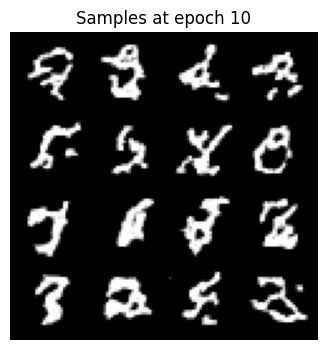

Epoch[11/100], Step[0/235], Loss=0.0494
Epoch[11/100], Step[100/235], Loss=0.0509
Epoch[11/100], Step[200/235], Loss=0.0506
Epoch 11 done. Avg Loss: 0.0496
Epoch[12/100], Step[0/235], Loss=0.0456
Epoch[12/100], Step[100/235], Loss=0.0479
Epoch[12/100], Step[200/235], Loss=0.0521
Epoch 12 done. Avg Loss: 0.0481
Epoch[13/100], Step[0/235], Loss=0.0501
Epoch[13/100], Step[100/235], Loss=0.0488
Epoch[13/100], Step[200/235], Loss=0.0469
Epoch 13 done. Avg Loss: 0.0471
Epoch[14/100], Step[0/235], Loss=0.0490
Epoch[14/100], Step[100/235], Loss=0.0471
Epoch[14/100], Step[200/235], Loss=0.0430
Epoch 14 done. Avg Loss: 0.0460
Epoch[15/100], Step[0/235], Loss=0.0435
Epoch[15/100], Step[100/235], Loss=0.0471
Epoch[15/100], Step[200/235], Loss=0.0450
Epoch 15 done. Avg Loss: 0.0455
Epoch[16/100], Step[0/235], Loss=0.0479
Epoch[16/100], Step[100/235], Loss=0.0421
Epoch[16/100], Step[200/235], Loss=0.0431
Epoch 16 done. Avg Loss: 0.0450
Epoch[17/100], Step[0/235], Loss=0.0463
Epoch[17/100], Step[100/

100%|██████████| 500/500 [00:02<00:00, 172.30it/s]


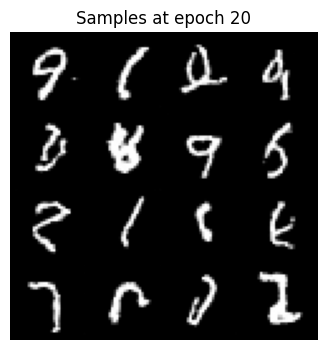

Epoch[21/100], Step[0/235], Loss=0.0395
Epoch[21/100], Step[100/235], Loss=0.0390
Epoch[21/100], Step[200/235], Loss=0.0419
Epoch 21 done. Avg Loss: 0.0427
Epoch[22/100], Step[0/235], Loss=0.0434
Epoch[22/100], Step[100/235], Loss=0.0414
Epoch[22/100], Step[200/235], Loss=0.0387
Epoch 22 done. Avg Loss: 0.0428
Epoch[23/100], Step[0/235], Loss=0.0429
Epoch[23/100], Step[100/235], Loss=0.0398
Epoch[23/100], Step[200/235], Loss=0.0393
Epoch 23 done. Avg Loss: 0.0423
Epoch[24/100], Step[0/235], Loss=0.0412
Epoch[24/100], Step[100/235], Loss=0.0457
Epoch[24/100], Step[200/235], Loss=0.0456
Epoch 24 done. Avg Loss: 0.0419
Epoch[25/100], Step[0/235], Loss=0.0410
Epoch[25/100], Step[100/235], Loss=0.0376
Epoch[25/100], Step[200/235], Loss=0.0376
Epoch 25 done. Avg Loss: 0.0417
Epoch[26/100], Step[0/235], Loss=0.0446
Epoch[26/100], Step[100/235], Loss=0.0446
Epoch[26/100], Step[200/235], Loss=0.0393
Epoch 26 done. Avg Loss: 0.0417
Epoch[27/100], Step[0/235], Loss=0.0405
Epoch[27/100], Step[100/

100%|██████████| 500/500 [00:02<00:00, 204.84it/s]


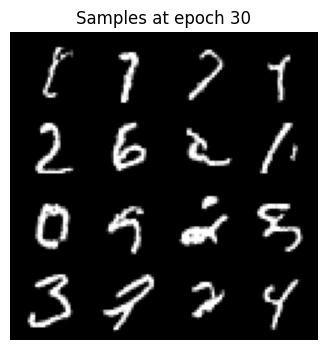

Epoch[31/100], Step[0/235], Loss=0.0370
Epoch[31/100], Step[100/235], Loss=0.0425
Epoch[31/100], Step[200/235], Loss=0.0407
Epoch 31 done. Avg Loss: 0.0407
Epoch[32/100], Step[0/235], Loss=0.0406
Epoch[32/100], Step[100/235], Loss=0.0410
Epoch[32/100], Step[200/235], Loss=0.0383
Epoch 32 done. Avg Loss: 0.0405
Epoch[33/100], Step[0/235], Loss=0.0433
Epoch[33/100], Step[100/235], Loss=0.0434
Epoch[33/100], Step[200/235], Loss=0.0384
Epoch 33 done. Avg Loss: 0.0406
Epoch[34/100], Step[0/235], Loss=0.0415
Epoch[34/100], Step[100/235], Loss=0.0428
Epoch[34/100], Step[200/235], Loss=0.0414
Epoch 34 done. Avg Loss: 0.0403
Epoch[35/100], Step[0/235], Loss=0.0432
Epoch[35/100], Step[100/235], Loss=0.0382
Epoch[35/100], Step[200/235], Loss=0.0416
Epoch 35 done. Avg Loss: 0.0401
Epoch[36/100], Step[0/235], Loss=0.0411
Epoch[36/100], Step[100/235], Loss=0.0386
Epoch[36/100], Step[200/235], Loss=0.0432
Epoch 36 done. Avg Loss: 0.0403
Epoch[37/100], Step[0/235], Loss=0.0397
Epoch[37/100], Step[100/

100%|██████████| 500/500 [00:02<00:00, 197.22it/s]


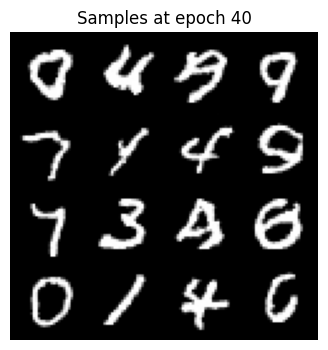

Epoch[41/100], Step[0/235], Loss=0.0398
Epoch[41/100], Step[100/235], Loss=0.0380
Epoch[41/100], Step[200/235], Loss=0.0380
Epoch 41 done. Avg Loss: 0.0396
Epoch[42/100], Step[0/235], Loss=0.0382
Epoch[42/100], Step[100/235], Loss=0.0392
Epoch[42/100], Step[200/235], Loss=0.0422
Epoch 42 done. Avg Loss: 0.0397
Epoch[43/100], Step[0/235], Loss=0.0398
Epoch[43/100], Step[100/235], Loss=0.0386
Epoch[43/100], Step[200/235], Loss=0.0391
Epoch 43 done. Avg Loss: 0.0394
Epoch[44/100], Step[0/235], Loss=0.0378
Epoch[44/100], Step[100/235], Loss=0.0415
Epoch[44/100], Step[200/235], Loss=0.0405
Epoch 44 done. Avg Loss: 0.0394
Epoch[45/100], Step[0/235], Loss=0.0433
Epoch[45/100], Step[100/235], Loss=0.0414
Epoch[45/100], Step[200/235], Loss=0.0428
Epoch 45 done. Avg Loss: 0.0392
Epoch[46/100], Step[0/235], Loss=0.0344
Epoch[46/100], Step[100/235], Loss=0.0426
Epoch[46/100], Step[200/235], Loss=0.0422
Epoch 46 done. Avg Loss: 0.0394
Epoch[47/100], Step[0/235], Loss=0.0373
Epoch[47/100], Step[100/

100%|██████████| 500/500 [00:02<00:00, 194.35it/s]


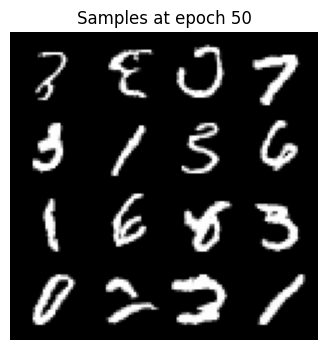

Epoch[51/100], Step[0/235], Loss=0.0371
Epoch[51/100], Step[100/235], Loss=0.0370
Epoch[51/100], Step[200/235], Loss=0.0421
Epoch 51 done. Avg Loss: 0.0390
Epoch[52/100], Step[0/235], Loss=0.0366
Epoch[52/100], Step[100/235], Loss=0.0430
Epoch[52/100], Step[200/235], Loss=0.0409
Epoch 52 done. Avg Loss: 0.0389
Epoch[53/100], Step[0/235], Loss=0.0368
Epoch[53/100], Step[100/235], Loss=0.0402
Epoch[53/100], Step[200/235], Loss=0.0416
Epoch 53 done. Avg Loss: 0.0389
Epoch[54/100], Step[0/235], Loss=0.0373
Epoch[54/100], Step[100/235], Loss=0.0362
Epoch[54/100], Step[200/235], Loss=0.0394
Epoch 54 done. Avg Loss: 0.0389
Epoch[55/100], Step[0/235], Loss=0.0417
Epoch[55/100], Step[100/235], Loss=0.0385
Epoch[55/100], Step[200/235], Loss=0.0419
Epoch 55 done. Avg Loss: 0.0388
Epoch[56/100], Step[0/235], Loss=0.0361
Epoch[56/100], Step[100/235], Loss=0.0373
Epoch[56/100], Step[200/235], Loss=0.0386
Epoch 56 done. Avg Loss: 0.0390
Epoch[57/100], Step[0/235], Loss=0.0358
Epoch[57/100], Step[100/

100%|██████████| 500/500 [00:02<00:00, 194.43it/s]


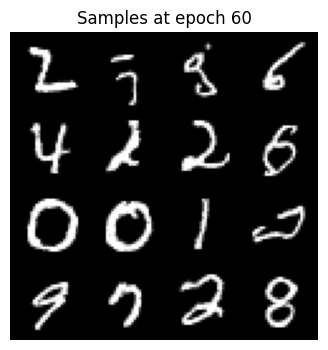

Epoch[61/100], Step[0/235], Loss=0.0355
Epoch[61/100], Step[100/235], Loss=0.0406
Epoch[61/100], Step[200/235], Loss=0.0381
Epoch 61 done. Avg Loss: 0.0385
Epoch[62/100], Step[0/235], Loss=0.0430
Epoch[62/100], Step[100/235], Loss=0.0392
Epoch[62/100], Step[200/235], Loss=0.0348
Epoch 62 done. Avg Loss: 0.0385
Epoch[63/100], Step[0/235], Loss=0.0399
Epoch[63/100], Step[100/235], Loss=0.0381
Epoch[63/100], Step[200/235], Loss=0.0422
Epoch 63 done. Avg Loss: 0.0383
Epoch[64/100], Step[0/235], Loss=0.0388
Epoch[64/100], Step[100/235], Loss=0.0412
Epoch[64/100], Step[200/235], Loss=0.0395
Epoch 64 done. Avg Loss: 0.0383
Epoch[65/100], Step[0/235], Loss=0.0385
Epoch[65/100], Step[100/235], Loss=0.0378
Epoch[65/100], Step[200/235], Loss=0.0435
Epoch 65 done. Avg Loss: 0.0381
Epoch[66/100], Step[0/235], Loss=0.0413
Epoch[66/100], Step[100/235], Loss=0.0377
Epoch[66/100], Step[200/235], Loss=0.0350
Epoch 66 done. Avg Loss: 0.0383
Epoch[67/100], Step[0/235], Loss=0.0386
Epoch[67/100], Step[100/

100%|██████████| 500/500 [00:02<00:00, 191.90it/s]


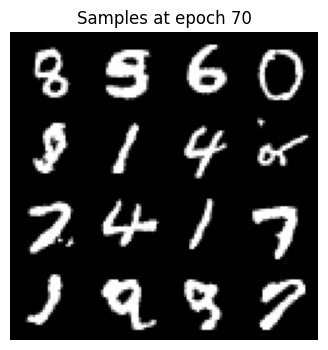

Epoch[71/100], Step[0/235], Loss=0.0392
Epoch[71/100], Step[100/235], Loss=0.0383
Epoch[71/100], Step[200/235], Loss=0.0396
Epoch 71 done. Avg Loss: 0.0380
Epoch[72/100], Step[0/235], Loss=0.0397
Epoch[72/100], Step[100/235], Loss=0.0348
Epoch[72/100], Step[200/235], Loss=0.0448
Epoch 72 done. Avg Loss: 0.0381
Epoch[73/100], Step[0/235], Loss=0.0401
Epoch[73/100], Step[100/235], Loss=0.0369
Epoch[73/100], Step[200/235], Loss=0.0357
Epoch 73 done. Avg Loss: 0.0381
Epoch[74/100], Step[0/235], Loss=0.0397
Epoch[74/100], Step[100/235], Loss=0.0408
Epoch[74/100], Step[200/235], Loss=0.0413
Epoch 74 done. Avg Loss: 0.0383
Epoch[75/100], Step[0/235], Loss=0.0370
Epoch[75/100], Step[100/235], Loss=0.0362
Epoch[75/100], Step[200/235], Loss=0.0379
Epoch 75 done. Avg Loss: 0.0378
Epoch[76/100], Step[0/235], Loss=0.0410
Epoch[76/100], Step[100/235], Loss=0.0440
Epoch[76/100], Step[200/235], Loss=0.0370
Epoch 76 done. Avg Loss: 0.0380
Epoch[77/100], Step[0/235], Loss=0.0344
Epoch[77/100], Step[100/

100%|██████████| 500/500 [00:02<00:00, 199.01it/s]


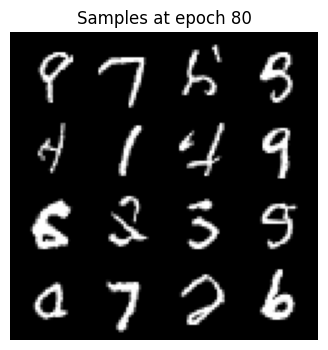

Epoch[81/100], Step[0/235], Loss=0.0385
Epoch[81/100], Step[100/235], Loss=0.0372
Epoch[81/100], Step[200/235], Loss=0.0385
Epoch 81 done. Avg Loss: 0.0379
Epoch[82/100], Step[0/235], Loss=0.0376
Epoch[82/100], Step[100/235], Loss=0.0373
Epoch[82/100], Step[200/235], Loss=0.0381
Epoch 82 done. Avg Loss: 0.0379
Epoch[83/100], Step[0/235], Loss=0.0372
Epoch[83/100], Step[100/235], Loss=0.0379
Epoch[83/100], Step[200/235], Loss=0.0378
Epoch 83 done. Avg Loss: 0.0378
Epoch[84/100], Step[0/235], Loss=0.0382
Epoch[84/100], Step[100/235], Loss=0.0404
Epoch[84/100], Step[200/235], Loss=0.0392
Epoch 84 done. Avg Loss: 0.0379
Epoch[85/100], Step[0/235], Loss=0.0390
Epoch[85/100], Step[100/235], Loss=0.0353
Epoch[85/100], Step[200/235], Loss=0.0413
Epoch 85 done. Avg Loss: 0.0379
Epoch[86/100], Step[0/235], Loss=0.0341
Epoch[86/100], Step[100/235], Loss=0.0406
Epoch[86/100], Step[200/235], Loss=0.0391
Epoch 86 done. Avg Loss: 0.0377
Epoch[87/100], Step[0/235], Loss=0.0398
Epoch[87/100], Step[100/

In [ ]:
# Feel free to tweak the below call as you like.
train_mnist_diffusion(
    lr=1e-3,
    batch_size=256,
    epochs=100,
    timesteps=500,
    model_base_dim=32,
    device="cuda" if torch.cuda.is_available() else "cpu",
    log_freq=100,
    show_every=10,
    n_samples=16,
)